In [1]:
import torch

torch.__version__
torch.cuda.is_available()

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(1)}")
else:
    print("GPU is not available")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"Using device: {device}")

GPU is available: NVIDIA GeForce RTX 3090
Using device: cuda
Using device: cuda


In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class LungDataset(Dataset):
    def __init__(self,image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))

        self.transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
        ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        mask_name = img_name.replace(".jpg", "_mask.png")
        
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask
    



    


In [3]:
from torch.utils.data import DataLoader

dataset = LungDataset("../dataset/Chest-X-Ray/Chest-X-Ray/image","../dataset/Chest-X-Ray/Chest-X-Ray/mask")
loader = DataLoader(dataset, batch_size = 4, shuffle= True)

for images, masks in loader:
    print(images.shape)
    print(masks.shape)
    break


torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


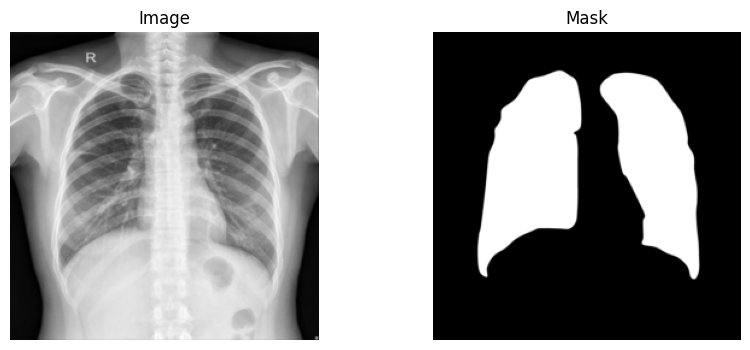

In [4]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size = 1, shuffle= True)

image, mask = next(iter(loader))
image = image.squeeze().numpy()
mask = mask.squeeze().numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 인코더 (Down)
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # 디코더 (Up)
        self.up1 = self.up_block(256, 128)
        self.up2 = self.up_block(128, 64)

        # 최종 출력 (1채널 마스크)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # 인코딩
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool2d(x1, 2))
        x3 = self.enc3(F.max_pool2d(x2, 2))

        # 디코딩
        x = self.up1(x3)
        x = self.up2(x)

        # 출력
        x = self.final_conv(x)
        x = torch.sigmoid(x)  # binary mask니까 sigmoid
        return x


In [6]:
model = UNet()
x = torch.randn(1, 1, 256, 256)  # (batch=1, channel=1, H=256, W=256)
output = model(x)

print("입력:", x.shape)
print("출력:", output.shape)


입력: torch.Size([1, 1, 256, 256])
출력: torch.Size([1, 1, 256, 256])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [20]:
from torch.utils.data import DataLoader

dataset = LungDataset("../dataset/Chest-X-Ray/Chest-X-Ray/image","../dataset/Chest-X-Ray/Chest-X-Ray/mask")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # 학습 모드
    epoch_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # U-Net 결과
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")


[Epoch 1] Loss: 0.4017
[Epoch 2] Loss: 0.2122
[Epoch 3] Loss: 0.1612
[Epoch 4] Loss: 0.1270
[Epoch 5] Loss: 0.1026


In [9]:
import mlflow
import mlflow.pytorch


/home/kmj388/micromamba/envs/iris-mlops/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [10]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("unet-experiment")


<Experiment: artifact_location='s3://mlflow-artifacts/1', creation_time=1754025710977, experiment_id='1', last_update_time=1754025710977, lifecycle_stage='active', name='unet-experiment', tags={}>

In [11]:
with mlflow.start_run():
    # 🧾 파라미터 기록
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("batch_size", 1)
    mlflow.log_param("lr", 0.001)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")
        mlflow.log_metric("loss", avg_loss, step=epoch)

    # ✅ 모델 저장
    mlflow.pytorch.log_model(model, "unet-model")

    # 🎨 예측 마스크 하나 저장해서 이미지로 기록해보기
    model.eval()
    sample_img, _ = next(iter(loader))
    sample_img = sample_img.to(device)
    with torch.no_grad():
        pred_mask = model(sample_img)

    # 첫 번째 마스크만 시각화 저장
    import matplotlib.pyplot as plt
    import numpy as np

    pred_np = pred_mask[0][0].cpu().numpy()
    os.makedirs("outputs", exist_ok=True)
    plt.imsave("outputs/sample_pred_mask.png", pred_np, cmap='gray')
    mlflow.log_artifact("outputs/sample_pred_mask.png")

NameError: name 'num_epochs' is not defined

In [12]:
os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'mlflowpass' 
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:30001'

print("환경 변수 설정 완료!")
print(f"AWS_ACCESS_KEY_ID: {os.environ.get('AWS_ACCESS_KEY_ID')}")
print(f"MLFLOW_S3_ENDPOINT_URL: {os.environ.get('MLFLOW_S3_ENDPOINT_URL')}")

환경 변수 설정 완료!
AWS_ACCESS_KEY_ID: mlflow
MLFLOW_S3_ENDPOINT_URL: http://localhost:30001


In [13]:
mlflow.pytorch.log_model(model, "unet-model")

2025/08/01 06:16:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 06:16:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'mathmodule'}


In [ ]:
# train_unet_with_mlflow.py12313

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
import torchvision.transforms as T
import os
from unet import UNet
from dataset import LungDataset
import argparse
from dotenv import load_dotenv

load_dotenv()
job_name = os.getenv("name")

parser = argparse.ArgumentParser()
parser.add_argument("--data_dir", type=str, default="Chest-X-Ray", help="Data directory")
parser.add_argument("--batch_size", type=int, default=32, help="Batch size")
parser.add_argument("--lr", type=float, default=0.001, help="Learning rate")
parser.add_argument("--num_epochs", type=int, default=5, help="Number of epochs")
args = parser.parse_args()

image_dir = os.path.join(args.data_dir, "image")
mask_dir = os.path.join(args.data_dir, "mask")

# 하이퍼파라미터
num_epochs = args.num_epochs
batch_size = args.batch_size
lr = args.lr

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])
dataset = LungDataset(image_dir, mask_dir, transform=transform)
loader = DataLoader(
    dataset, 
    batch_size=32,          # 배치 크기 줄이기 (64 → 32)
    shuffle=True,
    num_workers=2,          # 워커 수 제한 (기본값 0)
    pin_memory=False,       # 메모리 피닝 비활성화
    persistent_workers=True # 워커 재사용 (Python 3.7+)
)

# 모델 & 학습 설정1313213
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# MLflow 설정
mlflow.set_tracking_uri("http://mlflow-service:5000")
mlflow.set_experiment("unet-lung-segmentation")

with mlflow.start_run():
    mlflow.set_tag("job_name", job_name)
    mlflow.log_param("lr", lr)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", num_epochs)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")
        mlflow.log_metric("loss", avg_loss, step=epoch)

    # 모델 저장
    mlflow.pytorch.log_model(model, "model")

    # 예측 이미지 저장
    model.eval()
    sample, _ = next(iter(loader))
    with torch.no_grad():
        pred = model(sample.to(device))
    pred_np = pred[0][0].cpu().numpy()
    import matplotlib.pyplot as plt
    os.makedirs("outputs", exist_ok=True)
    plt.imsave("outputs/predicted.png", pred_np, cmap='gray')
    mlflow.log_artifact("outputs/predicted.png")
